In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import visual_behavior_glm
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat

import visual_behavior.data_access.loading as loading
import tensortools
import umap
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# TCA on GLM results - all cells, sorted by session variables
The goal of this notebook is to expand on the TCA analysis performed on GLM results per-container by combining cells across containers. To compensate for the fact that sessions within each container may have been collected in different orders, we sort the sessions by variables such as `number of exposures to novel image set`.

Session variables to try: 
* Omission exposure number
* Novel image set exposure number - This one would be particularly cool if there are some familiar and some novel images in the second image set (Images G/H data).

In [2]:
experiments_table = loading.get_filtered_ophys_experiment_table()

In [3]:
model_output_type = 'adj_fraction_change_from_full'
glm_version = '9a_L2_optimize_by_session'

In [4]:
rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=0.01)

In [5]:
clustering_features = [
    'all-images',
    'image0',
    'image1',
    'image2',
    'image3',
    'image4',
    'image5',
    'image6',
    'image7',
    'omissions',
    'behavioral',
        #'licking',
    'pupil',
    'running',
    'face_motion_PC_0',
    'face_motion_PC_1'
]

In [6]:
slc_data = rspm.query("cre_line=='Slc17a7-IRES2-Cre'")

In [7]:
list(slc_data.columns)

['identifier',
 'Full',
 'all-images',
 'beh_model',
 'behavioral',
 'cognitive',
 'correct_rejects',
 'expectation',
 'face_motion_PC_0',
 'face_motion_PC_1',
 'face_motion_PC_2',
 'face_motion_PC_3',
 'face_motion_PC_4',
 'face_motion_energy',
 'false_alarms',
 'hits',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'licking',
 'licks',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'passive_change',
 'pupil',
 'pupil_and_omissions',
 'pupil_and_running',
 'running',
 'running_and_omissions',
 'single-all-images',
 'single-beh_model',
 'single-behavioral',
 'single-cognitive',
 'single-correct_rejects',
 'single-expectation',
 'single-face_motion_PC_0',
 'single-face_motion_PC_1',
 'single-face_motion_PC_2',
 'single-face_motion_PC_3',
 'single-face_motion_PC_4',
 'single-face_motion_energy',
 'single-false_alarms',
 'single-hits',
 'single-image0',
 'single-

In [8]:
sns.set_context('talk')

/home/nick.ponvert/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


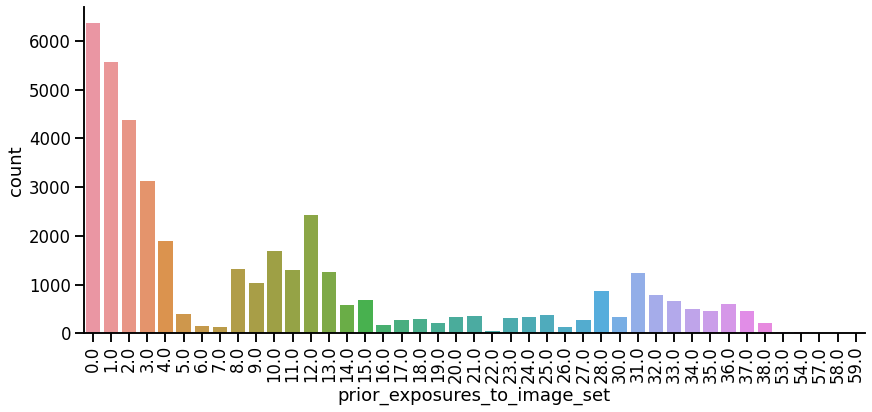

In [9]:
sns.countplot(slc_data['prior_exposures_to_image_set'])
plt.gcf().set_size_inches(14, 6)
plt.xticks(rotation=90);
sns.despine()

### For the images_B data only

In [10]:
novel_image_B_sessions = ['OPHYS_4_images_B', 'OPHYS_5_images_B_passive', 'OPHYS_6_images_B']
novel_image_data = slc_data[slc_data['session_type'].isin(novel_image_B_sessions)]

In [11]:
novel_image_data

,identifier,Full,all-images,beh_model,behavioral,cognitive,correct_rejects,expectation,face_motion_PC_0,face_motion_PC_1,...,super_container_id,cre_line,session_tags,failure_tags,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,model_outputs_available,location,session_number
6527,788490510_962635578,0.0,-0.089384,-0.084329,-0.389291,-0.105907,0.000000,-0.055117,0.000000,0.000000,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6528,788490510_962635598,0.0,-0.299049,-0.221667,-0.457356,-0.284395,0.000000,0.000000,0.000000,0.000000,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6529,788490510_962635609,0.0,-0.424891,-0.146427,-0.191111,-0.142727,-0.023512,-0.006765,0.000000,0.000000,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6530,788490510_962635620,0.0,-0.339990,0.000000,-0.231676,0.000000,0.000000,0.000000,0.000000,-0.020549,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6531,788490510_962635639,0.0,-0.219452,-0.011971,-0.496733,-0.027527,0.000000,-0.008729,-0.002544,-0.000422,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66336,994082683_1017245754,0.0,-0.804058,-0.001849,-0.004810,-0.000596,0.000000,-0.013673,0.000000,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0
66337,994082683_1017245757,0.0,-0.075957,0.000000,-0.497023,-0.149365,0.000000,-0.031774,-0.014668,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0
66338,994082683_1017245760,0.0,-0.315293,-0.001971,-0.113975,0.000000,0.000000,-0.062758,0.000000,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0
66339,994082683_1017245763,0.0,-0.268243,0.000000,0.000000,-0.014339,-0.003547,-0.094008,0.000000,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0


In [12]:
slc_data['session_number'].unique()

array([2., 3., 5., 4., 6., 1.])

In [13]:
slc_data['session_type'].unique()

array(['OPHYS_2_images_B_passive', 'OPHYS_3_images_G',
       'OPHYS_2_images_G_passive', 'OPHYS_5_images_A_passive',
       'OPHYS_4_images_H', 'OPHYS_5_images_H_passive', 'OPHYS_6_images_H',
       'OPHYS_1_images_B', 'OPHYS_3_images_B', 'OPHYS_4_images_A',
       'OPHYS_6_images_A', 'OPHYS_1_images_A', 'OPHYS_2_images_A_passive',
       'OPHYS_6_images_B', 'OPHYS_3_images_A', 'OPHYS_4_images_B',
       'OPHYS_5_images_B_passive', 'OPHYS_1_images_G'], dtype=object)

In [14]:
len(novel_image_data)

12479

/home/nick.ponvert/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


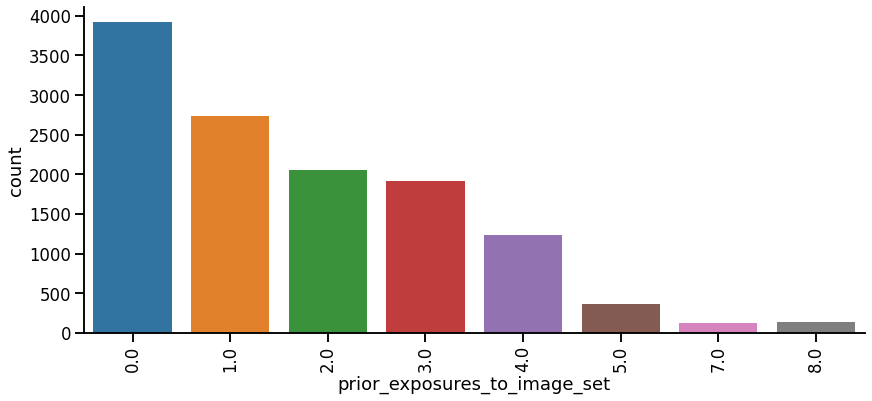

In [15]:
sns.countplot(novel_image_data['prior_exposures_to_image_set'])
plt.gcf().set_size_inches(14, 6)
plt.xticks(rotation=90);
sns.despine()

In [16]:
exposure_min = 0
exposure_max = 2
exposure_limited_data = novel_image_data.query(
    'prior_exposures_to_image_set >= @exposure_min and prior_exposures_to_image_set <= @exposure_max'
)

In [17]:
exposure_limited_data

,identifier,Full,all-images,beh_model,behavioral,cognitive,correct_rejects,expectation,face_motion_PC_0,face_motion_PC_1,...,super_container_id,cre_line,session_tags,failure_tags,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,model_outputs_available,location,session_number
6527,788490510_962635578,0.0,-0.089384,-0.084329,-0.389291,-0.105907,0.000000,-0.055117,0.000000,0.000000,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6528,788490510_962635598,0.0,-0.299049,-0.221667,-0.457356,-0.284395,0.000000,0.000000,0.000000,0.000000,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6529,788490510_962635609,0.0,-0.424891,-0.146427,-0.191111,-0.142727,-0.023512,-0.006765,0.000000,0.000000,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6530,788490510_962635620,0.0,-0.339990,0.000000,-0.231676,0.000000,0.000000,0.000000,0.000000,-0.020549,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
6531,788490510_962635639,0.0,-0.219452,-0.011971,-0.496733,-0.027527,0.000000,-0.008729,-0.002544,-0.000422,...,722884882.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,0.0,17.0,True,Slc17a7_VISp_375,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66336,994082683_1017245754,0.0,-0.804058,-0.001849,-0.004810,-0.000596,0.000000,-0.013673,0.000000,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0
66337,994082683_1017245757,0.0,-0.075957,0.000000,-0.497023,-0.149365,0.000000,-0.031774,-0.014668,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0
66338,994082683_1017245760,0.0,-0.315293,-0.001971,-0.113975,0.000000,0.000000,-0.062758,0.000000,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0
66339,994082683_1017245763,0.0,-0.268243,0.000000,0.000000,-0.014339,-0.003547,-0.094008,0.000000,0.000000,...,935565389.0,Slc17a7-IRES2-Cre,NaN,NaN,1.0,1.0,6.0,True,Slc17a7_VISl_271,4.0


In [18]:
pd.melt(exposure_limited_data,
        value_vars=clustering_features,
        id_vars=['cell_specimen_id', 'prior_exposures_to_image_set'])

,cell_specimen_id,prior_exposures_to_image_set,variable,value
0,962635578,0.0,all-images,-0.089384
1,962635598,0.0,all-images,-0.299049
2,962635609,0.0,all-images,-0.424891
3,962635620,0.0,all-images,-0.339990
4,962635639,0.0,all-images,-0.219452
...,...,...,...,...
130660,1017245754,1.0,face_motion_PC_1,0.000000
130661,1017245757,1.0,face_motion_PC_1,0.000000
130662,1017245760,1.0,face_motion_PC_1,0.000000
130663,1017245763,1.0,face_motion_PC_1,0.000000


In [19]:
data_xr = (
    pd.melt(exposure_limited_data, value_vars=clustering_features, id_vars=['cell_specimen_id', 'prior_exposures_to_image_set'])
    .set_index(['cell_specimen_id', 'variable', 'prior_exposures_to_image_set'])
    .to_xarray()
 )

In [20]:
data_xr

<xarray.Dataset>
Dimensions:                       (cell_specimen_id: 6600, prior_exposures_to_image_set: 3, variable: 15)
Coordinates:
  * cell_specimen_id              (cell_specimen_id) int64 853397924 ... 1028826664
  * variable                      (variable) object 'all-images' ... 'running'
  * prior_exposures_to_image_set  (prior_exposures_to_image_set) float64 0.0 ... 2.0
Data variables:
    value                         (cell_specimen_id, variable, prior_exposures_to_image_set) float64 -0.2712 ... -0.001037

In [21]:
data_arr = data_xr['value'].data
cells_present_all_sessions = np.logical_not(np.isnan(data_arr).any(axis=1).any(axis=1))
cells_in_all_sessions_arr = data_arr[cells_present_all_sessions, :, :]

In [22]:
data_arr.shape

(6600, 15, 3)

In [23]:
cells_in_all_sessions_arr.shape

(120, 15, 3)

In [24]:
cells_in_all_sessions_arr *= -1

In [25]:
## We can attempt to find the optimal rank for the decomposition via cross-validation. 
# It is pretty easy to do this since tensortools provides fit functions that can handle missing data.
# So, you can hold out some of your data to use as a validation set and compute the error on this set each rank.

# First, build the train and validation set masks

X = cells_in_all_sessions_arr

data_shape = X.shape
total_entries = data_shape[0]*data_shape[1]*data_shape[2]

# Get the inds (in the unraveled data array) to include in each mask
A = np.arange(total_entries)
train_inds, test_inds = train_test_split(A, test_size=0.25)
train_inds, validate_inds = train_test_split(train_inds, test_size=0.33)

# Build each mask
train_mask = np.zeros(total_entries)
train_mask[train_inds]=1
train_mask = train_mask.reshape(data_shape).astype(bool)

validate_mask = np.zeros(total_entries)
validate_mask[validate_inds]=1
validate_mask = validate_mask.reshape(data_shape).astype(bool)

test_mask = np.zeros(total_entries)
test_mask[test_inds]=1
test_mask = test_mask.reshape(data_shape).astype(bool)

# Make sure when we add the masks together every datapoint is selected
np.testing.assert_allclose((train_mask + validate_mask + test_mask).astype(int), np.ones(data_shape))

In [26]:
# Fit different ranks and evaluate the train and validation set error each time

ranks = range(1, 40)
fits = []
obj_train = []
obj_val = []

val_norm = np.linalg.norm(X * validate_mask)

for r in tqdm(ranks):
    U_train = tensortools.ncp_hals(X, mask=train_mask, rank=r, verbose=False)
    fits.append(U_train)
    obj_train.append(U_train.obj)
    
    # Compute and save the error on the held-out validation set
    obj_val.append(np.linalg.norm(validate_mask * (U_train.factors.full() - X)) / val_norm)

  0%|          | 0/39 [00:00<?, ?it/s]/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/home/nick.ponvert/.conda/envs/nick/lib/python3.7/site-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
100%|██████████| 39/39 [00:16<00:00,  2.38it/s]


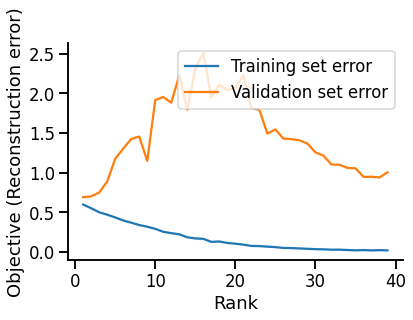

In [27]:
plt.plot(ranks, obj_train, label='Training set error')
plt.plot(ranks, obj_val, label='Validation set error')
plt.legend();
plt.ylabel('Objective (Reconstruction error)')
plt.xlabel('Rank');
sns.despine()

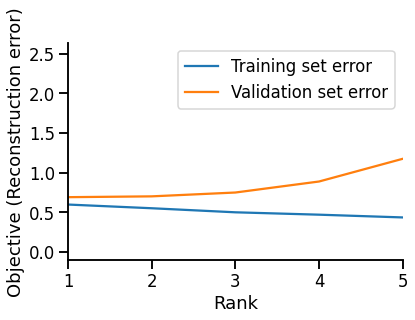

In [28]:
plt.plot(ranks, obj_train, label='Training set error')
plt.plot(ranks, obj_val, label='Validation set error')
plt.legend();
plt.ylabel('Objective (Reconstruction error)')
plt.xlabel('Rank');
plt.xlim([1, 5])
#plt.ylim(0.5, 0.8)
sns.despine()

In [29]:
tca_rank = 2
U = tensortools.ncp_hals(cells_in_all_sessions_arr, rank=tca_rank)

NCP_HALS: iteration 1, objective 0.6768085552079252, improvement inf.
NCP_HALS: iteration 2, objective 0.6461383716957895, improvement 0.030670183512135685.
NCP_HALS: iteration 3, objective 0.6395340539039194, improvement 0.006604317791870096.
NCP_HALS: iteration 4, objective 0.6367167337153852, improvement 0.0028173201885342003.
NCP_HALS: iteration 5, objective 0.6357503642570311, improvement 0.0009663694583540439.
NCP_HALS: iteration 6, objective 0.6354067190406256, improvement 0.00034364521640550816.
NCP_HALS: iteration 7, objective 0.6352623737224912, improvement 0.0001443453181344534.
NCP_HALS: iteration 8, objective 0.6351890356080354, improvement 7.333811445575655e-05.
NCP_HALS: iteration 9, objective 0.6351459207430086, improvement 4.31148650268387e-05.
NCP_HALS: iteration 10, objective 0.6351208158622069, improvement 2.5104880801651852e-05.
NCP_HALS: iteration 11, objective 0.6351061185991311, improvement 1.4697263075791334e-05.
NCP_HALS: iteration 12, objective 0.635097030688

In [30]:
def argsort_cells(U, ind_rank=0):
    '''
    Get a sorting order for the cell factors based off the cell weights for a particular rank.
    '''
    cell_weights = U.factors.factors[0][:, ind_rank]
    return np.argsort(cell_weights)

In [31]:
def tca_plot(U, sorting_ind_rank=0, cluster_labels=None):

    # Sort cells by cluster, or by one of the factors if no cluster labels supplied
    if cluster_labels is None:
        sorting_order = argsort_cells(U, sorting_ind_rank)
        bar_color = '0.2'
    else:
        sorting_order = np.argsort(cluster_labels)
        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        bar_color = [color_cycle[i] for i in cluster_labels[sorting_order]]

    num_factors = len(U.factors.factors)
    num_components = U.factors.rank
    fig, axes = plt.subplots(num_components, num_factors);
    fig.set_size_inches(16, 8)

    for ind_rank in range(num_components):

        # Plot cell factors, sorted
        cell_ax = axes[ind_rank, 0]
        cell_fac = U.factors.factors[0][:, ind_rank]
        cell_ax.bar(x=np.arange(len(cell_fac)), 
                    height=cell_fac[sorting_order],
                   color=bar_color)

        # Plot PSTH factors, sorted
        param_ax = axes[ind_rank, 1]
        param_fac = U.factors.factors[1][:, ind_rank]
        param_ax.plot(-1*param_fac, '-o', color='0.2')

        param_ax.set_xticks(range(len(param_fac)))
        param_ax.set_xticklabels([''] * len(param_fac))
        param_ax.axhline(y=0, color='0.5', ls='--')
        
        bound_starts = [0, 1, 9, 10, 12, 13]
        bound_ends =   [1, 9, 10, 12, 13, 15]
        light = '0.8'
        dark = '0.7'
        colors = [light, dark, light, dark, light, dark]
        for bound_start, bound_end, color in zip(bound_starts, bound_ends, colors):
            param_ax.axvspan(bound_start-0.5, bound_end-0.5, alpha=0.3, color=color)

        trial_ax = axes[ind_rank, 2]
        trial_fac = U.factors.factors[2][:, ind_rank]
        trial_ax.plot(trial_fac, 'k-')
        for ind_trial in range(len(trial_fac)):
            trial_ax.plot(ind_trial, trial_fac[ind_trial], 'o',
                     color='k', ms=8)
        trial_ax.set_xticks(range(len(trial_fac)))
        sns.despine()

    axes[-1, 0].set_xlabel('cell factor', fontsize=14)
    axes[-1, 1].set_xlabel('dropout score factor', fontsize=14)
    axes[-1, 1].set_xticklabels(clustering_features, rotation=60, ha='right')
    axes[-1, 2].set_xlabel('images_b exposure number factor', fontsize=14)

    plt.subplots_adjust(hspace=0.1)

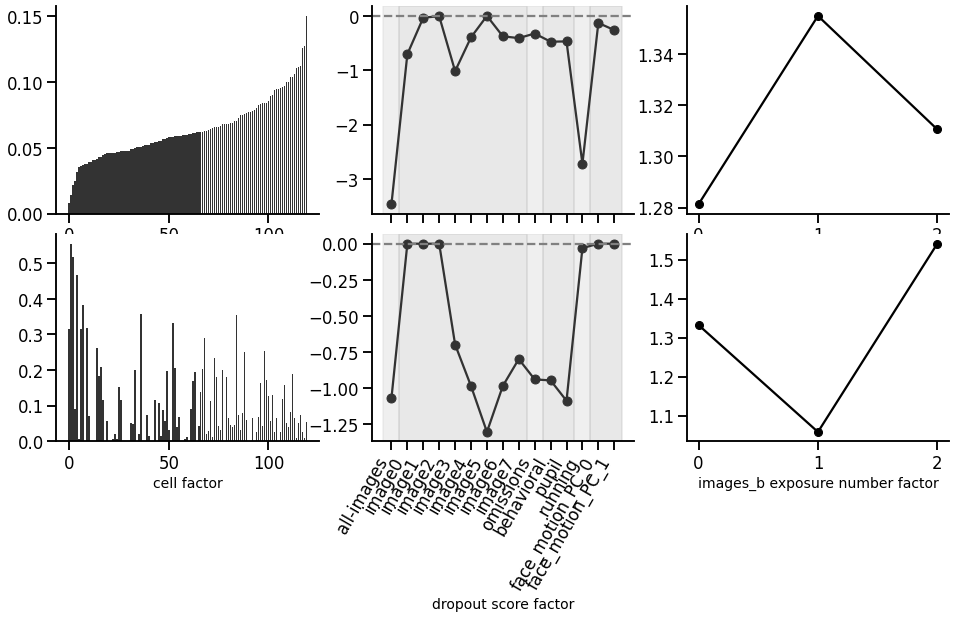

In [32]:
tca_plot(U)

In [33]:
cell_fac_data = pd.DataFrame(
    {f"factor_{i}": U.factors.factors[0][:, i] for i in range(tca_rank)}
)

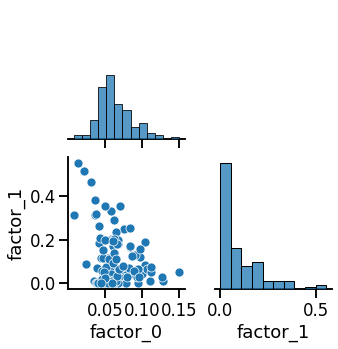

In [34]:
sns.pairplot(data=cell_fac_data, corner=True)